# Machine learning project: wine reviews


## About the data

The data that I am using is from the kaggle website:
https://www.kaggle.com/zynicide/wine-reviews/data

It's a concatenation of many wine reviews. 
Each review contains information about the winery, type of wine, region, 
as well as the name of the reviewer, the price, the number of points
and a description of the wine.

## Goal

The goal is to try to understand how much information about the 
quality of the wine can be guessed. 
First we will just look at the  "objective" characteristics, 
such as the type of wine, location and price.
This is not as objective as it seems, as it will have a lot to do with
how the reviewers pick the wines to review in the first place.
In a second time, we will try to extract information 
from the description of the wine, a long string of words.
This will necessitate feature engineering, as we will try to convert
the text into numbers that must correlate with the quality of the tested wine.

We will use always the same machine learning algorithm,
and then compare the score that we obtain by fitting it to different subsets of
the data.
This will be our measure of how much information about the target 
(number of points of the review)
there is in different subsets of the data.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import category_encoders as ce
import sklearn as skl

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plot parameters

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 14

## Importing the data 

In [3]:
# Open data

datafile = 'data/wine-reviews/winemag-data-130k-v2.csv'
data_small = pd.read_csv(datafile, nrows=10)

In [4]:
data_small

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


## Analysis of data content

We start by looking at the distributions and some correlations
between the different "features" of the data.

### Country of origin of the wine

First, we take a look at the distribution of the wine reviews according to
the country of origin of the wine. 
We see that the reviewers are based in the US, with a majority
of wine coming from there. 

['Italy' 'Portugal' 'US' 'Spain' 'France' 'Germany' 'Argentina' 'Chile'
 'Australia' 'Austria' 'South Africa' 'New Zealand' 'Israel' 'Hungary'
 'Greece' 'Romania' 'Mexico' 'Canada' nan 'Turkey' 'Czech Republic'
 'Slovenia' 'Luxembourg' 'Croatia' 'Georgia' 'Uruguay' 'England' 'Lebanon'
 'Serbia' 'Brazil' 'Moldova' 'Morocco' 'Peru' 'India' 'Bulgaria' 'Cyprus'
 'Armenia' 'Switzerland' 'Bosnia and Herzegovina' 'Ukraine' 'Slovakia'
 'Macedonia' 'China' 'Egypt'] country    43
dtype: int64
number of nans = country    63
dtype: int64


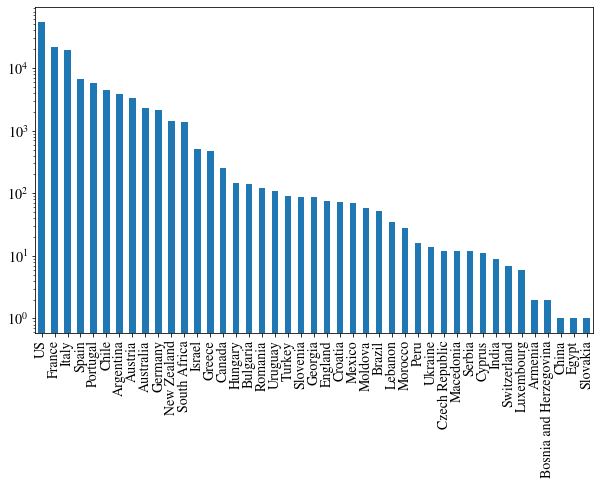

In [5]:
countries = pd.read_csv(datafile, usecols=[1])
print(countries.country.unique(), countries.nunique())
pd.value_counts(countries['country']).plot.bar(figsize=(10,6), logy=True)
count_nan = len(countries) - countries.count()
print('number of nans = {}'.format(count_nan))

In [6]:
# Designation

col_desig =pd.read_csv(datafile, usecols=[3])
print(col_desig.nunique())

designation    37979
dtype: int64


### Distribution of points

As we see below, the reviewers attribute points out of 100, but really only
in the window from 80 to 100 points.

number of nans = points    0
dtype: int64


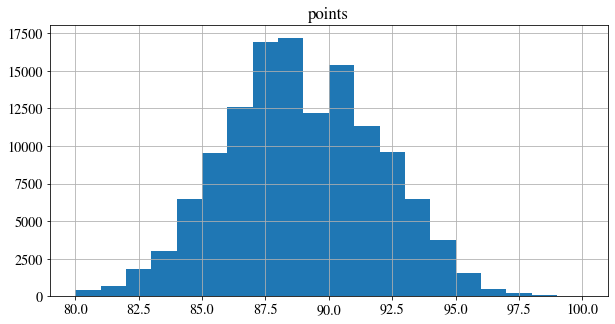

In [7]:
# Points
col_points =pd.read_csv(datafile, usecols=[4])
col_points.hist(bins=20)

count_nan = len(col_points) - col_points.count()
print('number of nans = {}'.format(count_nan))

### Prices

Prices vary wildly, with most bottles under \$100,
but a few costing over \$3000.
I expect that this is the feature that will the most strongly
correlate with the points and be most useful in prediction.
In the end, I decided to use a log scale to renormalize the 
prices. Interestingly, this gives a nice bell shape
for the distribution, with a most-likely price of about 
\$$10^{1.4}=25$.

number of nans = price    8996
dtype: int64


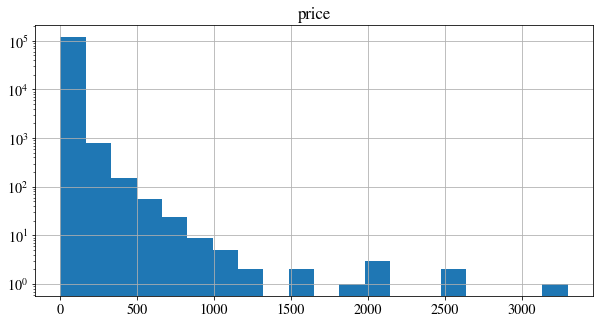

In [8]:
# Price
col_price =pd.read_csv(datafile, usecols=[5])
col_price.hist(bins=20, log=True)

count_nan = len(col_price) - col_price.count()
print('number of nans = {}'.format(count_nan))

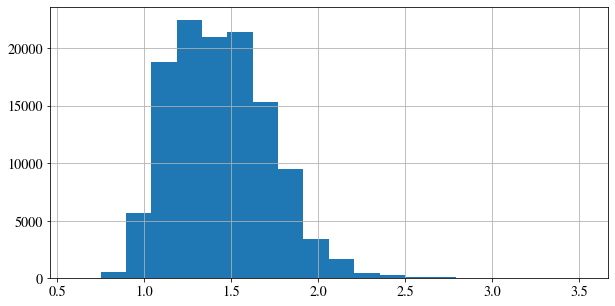

In [9]:
# Log of price histogram
col_price['price'].apply(np.log10).hist(bins=20)

### Tasters

Here as well as for the countries, 
the distribution is uneven we observe that a few tasters have done
most of the reviews.

taster_name    19
dtype: int64


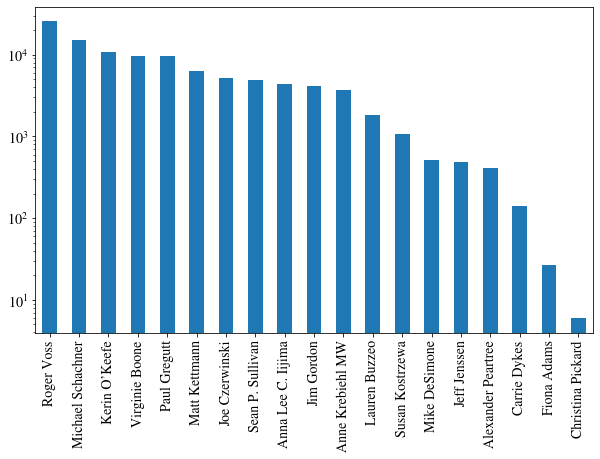

In [10]:
# Taster name


col_taster =pd.read_csv(datafile, usecols=[9])
print(col_taster.nunique())
pd.value_counts(col_taster['taster_name']).plot.bar(figsize=(10,6), logy=True)

In [11]:
# Varieties

col_vars =pd.read_csv(datafile, usecols=[12])
print(col_vars.nunique())

variety    707
dtype: int64


In [12]:
# Wineries

col_wineries =pd.read_csv(datafile, usecols=[13])
print(col_wineries.nunique())


winery    16757
dtype: int64


In [13]:
# Provinces

col_prov = pd.read_csv(datafile, usecols=[6])
print(col_prov.nunique())

count_nan = len(col_prov) - col_prov.count()
print('number of nans = {}'.format(count_nan))

province    425
dtype: int64
number of nans = province    63
dtype: int64


In [14]:
# Region 1

col_reg1 = pd.read_csv(datafile, usecols=[7])
print(col_reg1.nunique())

count_nan = len(col_reg1) - col_reg1.count()
print('number of nans = {}'.format(count_nan))

region_1    1229
dtype: int64
number of nans = region_1    21247
dtype: int64


In [15]:
# Region 2

col_reg2 = pd.read_csv(datafile, usecols=[8])
print(col_reg2.nunique())

count_nan = len(col_reg2) - col_reg2.count()
print('number of nans = {}'.format(count_nan))

# This is probably useless

region_2    17
dtype: int64
number of nans = region_2    79460
dtype: int64


## Correlation between price and points

As expected, we see a strong positive correlation between the price
of the wine and the number of points it got.
Is it a tribute to the objectivity of the price of wine, 
the better the more expensive,
or that the reviewers are swayed by the price of a costly drink?
Impossible here to tell unfortunately. It is certainly a bit of both.

Text(0, 0.5, 'points')

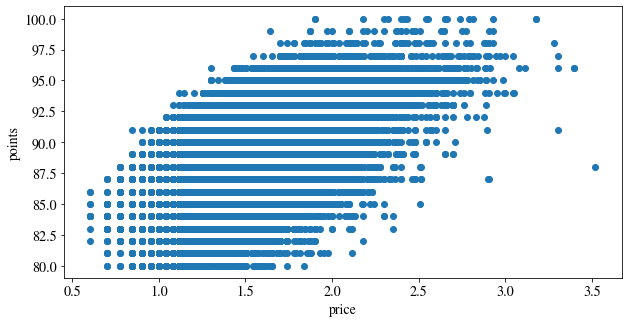

In [16]:
price_points = pd.read_csv(datafile, usecols=[4,5])
price_points['price'] = price_points['price'].apply(np.log10)

plt.scatter(price_points['price'], price_points['points'])
plt.xlabel('price')
plt.ylabel('points')


### How much data is missing

A few of the features miss quite a bit of time. 
In the end we decided to drop the "region 2" and "designation" features, 
as they are missing
in most data points, and anyway doe not seem to be that informative in general.


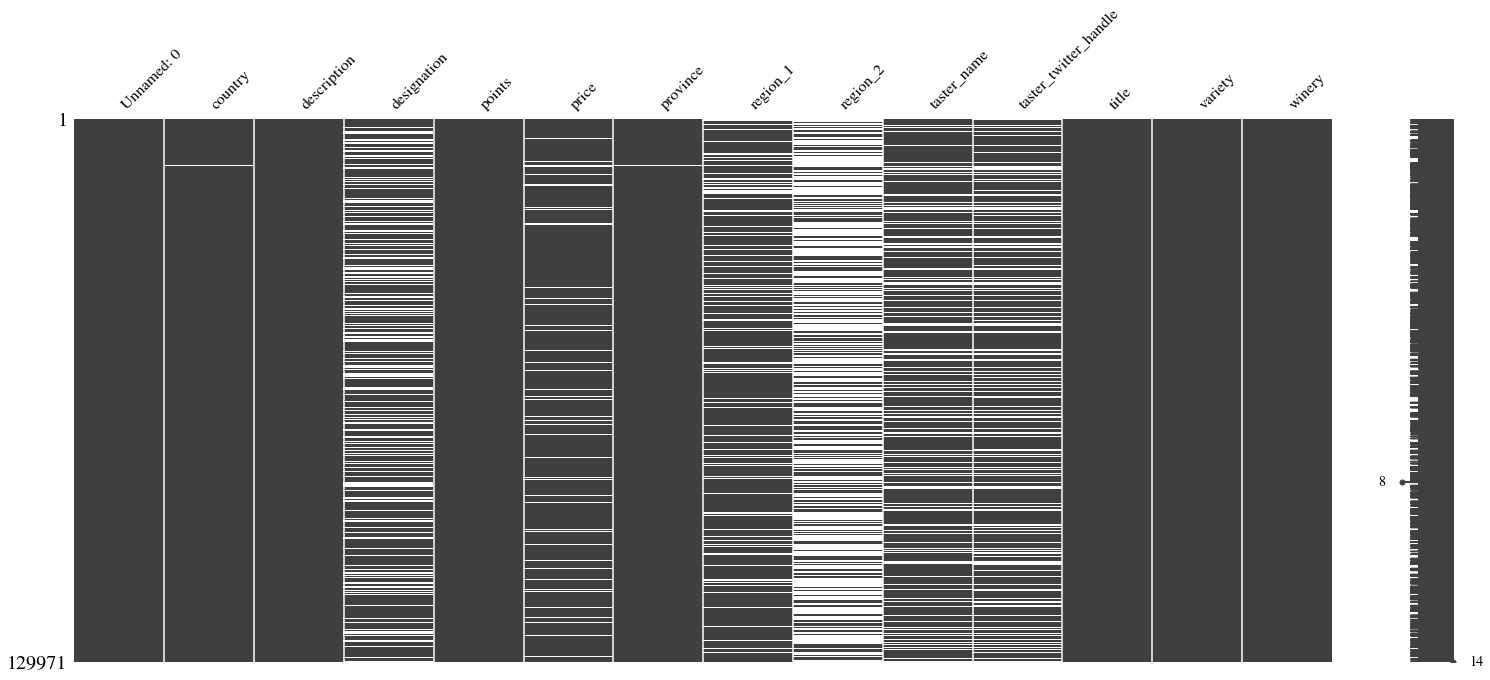

In [17]:
fulldata = pd.read_csv(datafile)
msno.matrix(fulldata)

## How much can we guess the rating from objective wine parameters

### First thing to do is to separate a chunk for testing

I tried to be very careful about information leakage by splitting
the data in a training and testing set as a first step.
Then we do some treatment of the training data, which we format
as functions, so that exactly the same treatment can be done
for the testing data.

The main problem is how to treat all the features which are strings. 
The different origin and types of the wine represent very diverse categories.
A one-hot encoding would be very impractical, as certain features
can be thousands of different categories. 
I chose to use the hashing encoding. 
This will remove a bit of information, but make sure
that the data does not become unwieldy.

As a first step, the choice is to try to guess the number of points
from all other characteristics. I chose 
to encode the grade as different categories (bad, average, good).
I made sure the distribution amongst those categories is more or less even
(with about a third of the reviews falling in each categories), such that 
it is not possible to get a good accuracy score by just betting
on the most likely categories. 

It might also be interesting to use the price as a target, 
to see if we can guess how much a wine costs by how well it is appreciated
by the reviewers.

In [18]:
from sklearn.model_selection import train_test_split

fulldata_train, fulldata_test = train_test_split(fulldata, test_size=0.1,
                                                random_state=18)

In [19]:
# As a first approach, we just drop data with missing samples
# We remove two columns with much missing values

def treat_data(dat):
    # make a function so that we can do the same procedure to the
    # test data later
    newdat = dat.drop(columns=['region_2','designation'])
    newdat = newdat.dropna()
    return newdat
    
fulldata_nona = treat_data(fulldata_train)
len(fulldata_nona)

66928

In [20]:
# Preparing data: separated in features (X) and label (y)

def make_xy(dat):
    # forget description for now
    X = dat.drop(
        columns=['description', 'title', 'taster_twitter_handle','points']) 
    # Price on log scale for nicer numbers
    X['price'] = X['price'].apply(np.log10)
    y = dat['points']
    return X, y

X_data,  y_data = make_xy(fulldata_nona)

In [21]:
# First approach: use hashing on categorical features

hashing = ce.HashingEncoder()
#Hashing function is "trained" on training data only
# to treat test data in the same way
hashing.fit(X_data, y_data)

HashingEncoder(cols=['country', 'province', 'region_1', 'taster_name',
                     'variety', 'winery'],
               drop_invariant=False, hash_method='md5', max_process=4,
               max_sample=16732, n_components=8, return_df=True, verbose=0)

In [22]:
def hashing_features(X):
    newX = hashing.transform(X)
    return newX

X_data_hashed = hashing_features(X_data)

87 90


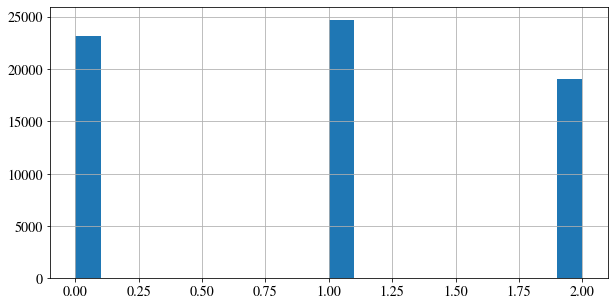

In [23]:
# Let's split scores into three equivalent bins: bad, average, good

length_data = len(y_data)
split1 = y_data.sort_values().values[length_data//3]
split2 = y_data.sort_values().values[-length_data//3]

print(split1, split2)

def splitting_func(points):
    # defined for training data only
    # testing data will be scaled the same
    if points <= split1:
        return 0
    elif points <= split2:
        return 1
    else:
        return 2

def rescale_points(y):
    newy = y.apply(splitting_func)
    return newy
    
y_data_binned = rescale_points(y_data)

y_data_binned.hist(bins=20)

## Fitting the data with a random forest

Since there are many features of different kinds, 
tree classifiers and random forests seem like the best option here.
We set up a random forest classifier (with a search grid in order to optimize parameters)
and use it always on different subsets of the data,
so that the model is always of the same kind and
we are just comparing the data.

We find that by fitting our original data, we
guess the right points category 58% of the time.
As we will see below, that is much better than random guessing.


In [24]:
# Prepare testing data in the same way

X_train, y_train = X_data_hashed, y_data_binned

X_test_init, y_test_init = make_xy(treat_data(fulldata_test))
X_test = hashing_features(X_test_init)
y_test = rescale_points(y_test_init)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
# Testing classification problem with random forests

param_grid = {
    'n_estimators': [100],
    'max_depth': [3,5,10]
}

gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, 
                  return_train_score=True, verbose=2, n_jobs=6)

In [27]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   26.2s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [28]:
print(gs.best_estimator_.score(X_train, y_train), 
      gs.best_estimator_.score(X_test, y_test))

0.6109550561797753 0.5793047256925584


### Baseline for estimating the score

As mentioned above, the target labels were split evenly so that 
there is a 1/3 chance to guess the right category purely by accident.
We check this with the dummy classifiers from sklearn, which
cannot get a score above 36% by uninformed guess.

This will provide the baseline for the scoring. If 
we can get a score larger than this, then this proves
that we can learn something from the data.
The higher the score, the more information
was contained in the data.

In [29]:
# Make a baseline for guesses

from sklearn.dummy import DummyClassifier

strategies = ['stratified', 'most_frequent', 'prior', 'uniform']#, 'constant']

for stra in strategies:
    dummy1 = DummyClassifier(strategy = stra)
    dummy1.fit(X_train, y_train)
    print('strategy {} gives a score of {}'.format(stra,dummy1.score(X_test, y_test)))

strategy stratified gives a score of 0.3320206409560022
strategy most_frequent gives a score of 0.36298207495926127
strategy prior gives a score of 0.36298207495926127
strategy uniform gives a score of 0.3321564367191744


### Is there more information in the wine origin or the price?

As expected, by just using the price, 
we have already quite a good guess,
with an accuracy of 56%.
Indeed, the price seems the most useful feature that correlates
most with the points.

In [30]:
# Drop all but price


gs.fit(X_train[['price']], y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   15.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [31]:
print(gs.best_estimator_.score(X_train[['price']], y_train), 
      gs.best_estimator_.score(X_test[['price']], y_test))

0.559750776954339 0.5621944595328626


In [32]:
# Drop the price


gs.fit(X_train.drop(columns='price'), y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   25.1s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [33]:
print(gs.best_estimator_.score(X_train.drop(columns='price'), y_train), 
      gs.best_estimator_.score(X_test.drop(columns='price'), y_test))

0.4989839827874731 0.45206409560021726


It is interesting that just by knowing the location and type of wine (and identity of the reviewer), 
we can still do a good guess whether the wine is good or not. 
This is most likely due to the fact that the list of wine is not random. The wines are chosen to be reviewed. If the reviewer chooses an exotic wine coming from a far away place, that is hard to obtain, they will most likely choose one with a good reputation rather than the local cheap wine. 


## Let's try now to extract information from the description of the wine

The description is a long string of words of different lengths,
for each wine. 
We need to treat the data in some way,
before it can be comprehended by a random forest.

### feature from number of words

The easiest thing to do with a long text to turn it into a number is simply to count the words. 
The assumption is that the length of the review will have something to do with
how much the reviewer enjoyed the wine.

As expected, better wines receive longer reviews. 
Surprisingly, the very best wines don't have the
absolute longest reviews, but rather there is a category between 92 and 98 points
that can get the longest reviews.

As a further check, it woud be interesting to study 
the correlation of the descripiton length with the wine reviewers.
Certainly some wine reviewers give longer reviews than others

Suprisingly, there seems to be much less of a clear correlation
between the description length and the price.
In that case, it would seem that price and description length
are good complementary informations to guess the number of points.

,descr_length
10684,31
78035,40
72938,41
90265,36
75304,27


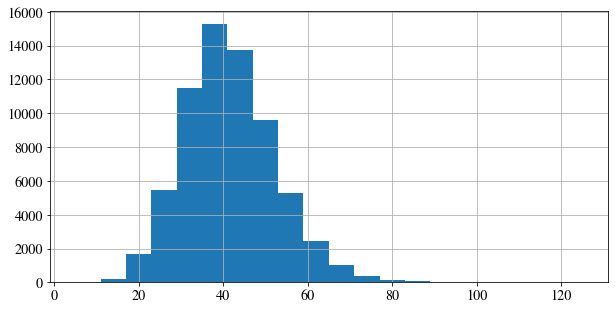

In [34]:

def count_words(d):
    words = d.split()
    cw = len(words)
    if np.isnan(cw):
        cw = 0
    return cw


def get_descr_length(dat):
    descr = dat[['description']]
    descr['descr_length'] = descr['description'].apply(count_words)
    return descr.drop(columns='description')

descr_length = get_descr_length(fulldata_nona)

descr_length['descr_length'].hist(bins=20)
descr_length.head()

In [35]:
descr_length.isnull().sum()

descr_length    0
dtype: int64

Text(0, 0.5, 'points')

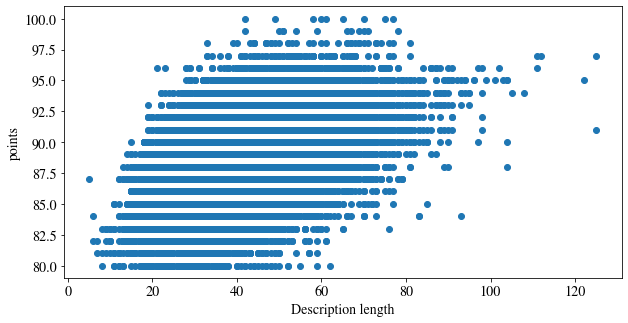

In [36]:
# Correlation between points of wine and number of words

plt.scatter(descr_length['descr_length'], fulldata_nona['points'])
plt.xlabel('Description length')
plt.ylabel('points')

Text(0, 0.5, 'price')

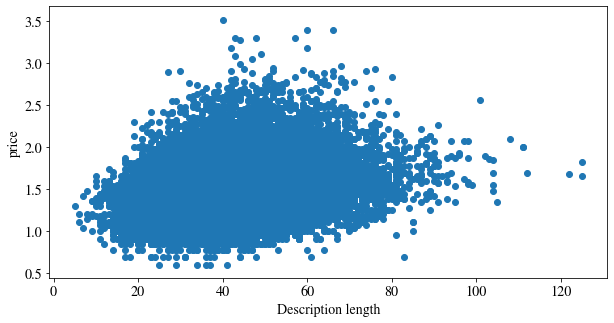

In [37]:
plt.scatter(descr_length['descr_length'], fulldata_nona['price'].apply(np.log10))
plt.xlabel('Description length')
plt.ylabel('price')

In [38]:
# Adding the new feature to the data


X_train['description_length'] =  descr_length['descr_length'].values

descr_le_test = get_descr_length(treat_data(fulldata_test))

X_test['description_length'] = descr_le_test['descr_length'].values

X_test.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Unnamed: 0,price,description_length
0,0,0,1,2,2,0,0,1,30684,1.041393,41
1,2,1,1,0,0,0,1,1,27343,1.653213,65
2,0,1,0,2,0,2,0,1,35514,0.903090,27
3,0,0,1,2,1,0,2,0,89077,1.397940,53
4,0,0,3,0,0,0,2,1,126252,1.681241,65


In [39]:
# Fit with description length


gs.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   26.1s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [40]:
print(gs.best_estimator_.score(X_train, y_train), 
      gs.best_estimator_.score(X_test, y_test))

0.6542104948601483 0.6224877783813145


Indeed we increase the score significantly by adding the description length 
as a new feature.

In [41]:
# What if we only keep this new feature


gs.fit(descr_length, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   13.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [42]:
print(gs.best_estimator_.score(descr_length, y_train), 
      gs.best_estimator_.score(descr_le_test, y_test))

0.49931269423858476 0.5101846822379141


This is almost as good as the price in order to predict the score of the wine.

## Conclusion

The idea was two-fold. 
First, I wanted to check whether it is possible 
to guess how much a reviewer will appreciate the wine
just by looking at the objective characteristics of the wine.
I found that we can guess almost 2 out of 3 times
whether the reviewer liked the wine or not, just
by looking at its origin, its price, and the name of the reviewer.

The second objective was to try to teach the machine learning algorithm
to "understand" the written description: if it means the wine is good or bad.
The description length, without analysing it, already gives a good idea.
Good wines inspire much longer reviews than bad wines.

### Outlook
There are several points that I would like to explore.
First, does a feature tend to increase or decrease the score.
For instance, I would like to check my assumption that an exotic wine
tends to have a better score than a domestic one.
Second, I would also like to check the characteristics of each wine taster.
Are certain wine tasters more critical? Do they write longer or shorter reviews?
Are they fond of a certain wine?

Finally, by analysing the preference of each wine taster,
one could perhaps construct a wine suggestion algorithm. 
For a given taster, due to past preferences, it would 
check whether a new wine is likely to please or not.